Copyright (c) MONAI Consortium  
Licensed under the Apache License, Version 2.0 (the "License");  
you may not use this file except in compliance with the License.  
You may obtain a copy of the License at  
&nbsp;&nbsp;&nbsp;&nbsp;http://www.apache.org/licenses/LICENSE-2.0  
Unless required by applicable law or agreed to in writing, software  
distributed under the License is distributed on an "AS IS" BASIS,  
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.  
See the License for the specific language governing permissions and  
limitations under the License.

# MAISI VAE Training Tutorial

This tutorial illustrates how to train the VAE model in MAISI on CT and MRI datasets. The VAE model is used for latent feature compression, which significantly reduce the memory usage of the diffusion model. The released VAE model weights can work on both CT and MRI images.

## Setup environment

In [1]:
!python -c "import monai" || pip install -q "monai-weekly[nibabel, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
!python -c "import tensorboard" || python -m pip install -U tensorboard
!python -c "import lpips" || python -m pip install -U lpips
%matplotlib inline

## Setup imports

In [2]:
import argparse
import glob
import json
import os
import tempfile
from pathlib import Path

import torch
from monai.networks.nets import PatchDiscriminator
from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import CacheDataset, DataLoader
from monai.inferers.inferer import SimpleInferer, SlidingWindowInferer
from monai.losses.adversarial_loss import PatchAdversarialLoss
from monai.losses.perceptual import PerceptualLoss
from monai.utils import set_determinism
from torch.amp import GradScaler, autocast
from torch.nn import L1Loss, MSELoss
from torch.optim import lr_scheduler
from torch.utils.tensorboard import SummaryWriter

from scripts.transforms import VAE_Transform
from scripts.utils import KL_loss, define_instance, dynamic_infer
from scripts.utils_plot import find_label_center_loc, get_xyz_plot, show_image
from scripts.download_model_data import download_model_data

import warnings

warnings.filterwarnings("ignore")

print_config()

MONAI version: 1.5.1+4.g69f3dd26
Numpy version: 2.2.6
Pytorch version: 2.9.0+cu128
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 69f3dd26ed2a65e89ae89d951bb16f2dcb4d7c5d
MONAI __file__: /localhome/<username>/.local/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.3.2
scikit-image version: 0.25.2
scipy version: 1.15.3
Pillow version: 12.0.0
Tensorboard version: 2.20.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.24.0+cu128
tqdm version: 4.67.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 7.1.0
pandas version: NOT INSTALLED or UNKNOWN VERSION.
einops version: 0.8.1
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOW

## Setup data directory
You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.
This allows you to save results and reuse downloads.
If not specified a temporary directory will be used.

In [3]:
os.environ["MONAI_DATA_DIRECTORY"] = "./temp_work_dir"
directory = os.environ.get("MONAI_DATA_DIRECTORY")
if directory is not None:
    os.makedirs(directory, exist_ok=True)
root_dir = tempfile.mkdtemp() if directory is None else directory

generate_version = "rflow-ct"
download_model_data(generate_version,root_dir, model_only=True)

saved to: ['models/autoencoder_v1.pt']
saved to: ['models/mask_generation_autoencoder.pt']
saved to: ['models/mask_generation_diffusion_unet.pt']
saved to: ['models/diff_unet_3d_rflow-ct.pt']
saved to: ['models/controlnet_3d_rflow-ct.pt']


## Download dataset

This tutorial shows how to train a VAE with both CT and MRI data. We use MSD 09 Spleen segmentation and MSD 01 Brats16&17 Brain Tumor segmentation as examples. The dataset comes from http://medicaldecathlon.com/.

This is just an example on how to build a multi-modal training dataset with both CT and MRI involved. Users can choose their own training datasets.

For the released trained autoencoder model weights, we used CT and MRI data from [TCIA Covid 19 Chest CT](https://wiki.cancerimagingarchive.net/display/Public/CT+Images+in+COVID-19#70227107b92475d33ae7421a9b9c426f5bb7d5b3), [TCIA Colon Abdomen CT](https://wiki.cancerimagingarchive.net/pages/viewpage.action?pageId=3539213), [MSD03 Liver Abdomen CT](http://medicaldecathlon.com/), [LIDC chest CT](https://www.cancerimagingarchive.net/collection/lidc-idri/), [TCIA Stony Brook Covid Chest CT](https://www.cancerimagingarchive.net/collection/covid-19-ny-sbu/), [NLST Chest CT](https://www.cancerimagingarchive.net/collection/nlst/), [TCIA Upenn GBM Brain MR](https://wiki.cancerimagingarchive.net/pages/viewpage.action?pageId=70225642), [Aomic Brain MR](https://openneuro.org/datasets/ds003097/versions/1.2.1), [QTIM Brain MR](https://openneuro.org/datasets/ds004169/versions/1.0.7), [TCIA Acrin Chest MR](https://www.cancerimagingarchive.net/collection/acrin-contralateral-breast-mr/), [TCIA Prostate MR Below-Abdomen MR](https://wiki.cancerimagingarchive.net/pages/viewpage.action?pageId=68550661#68550661a2c52df5969d435eae49b9669bea21a6). In total, we have
- number of CT training data: 37243
- number of MRI training data: 17887
- number of CT validation data:1963
- number of MRI validation data: 940

In [4]:
demo_train_data_rootdir = os.path.join(root_dir, "demo_train_datasets")

# MSD Spleen CT data
resource = "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task09_Spleen.tar"
md5 = "410d4a301da4e5b2f6f86ec3ddba524e"

compressed_file = os.path.join(demo_train_data_rootdir, "Task09_Spleen.tar")
data_path_1 = os.path.join(demo_train_data_rootdir, "Task09_Spleen")
if not os.path.exists(data_path_1):
    download_and_extract(resource, compressed_file, demo_train_data_rootdir, md5)

# Only include 5 of the images for quick demo purpose
train_images_1 = sorted(glob.glob(os.path.join(data_path_1, "imagesTr", "*.nii.gz")))[:5]
data_dicts_1 = [{"image": image_name} for image_name in train_images_1]
len_train = int(0.8 * len(data_dicts_1))
train_files_1, val_files_1 = data_dicts_1[:len_train], data_dicts_1[len_train:]

# MSD Brats MRI data
resource = "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task01_BrainTumour.tar"
md5 = "240a19d752f0d9e9101544901065d872"

compressed_file = os.path.join(demo_train_data_rootdir, "Task01_BrainTumour.tar")
data_path_2 = os.path.join(demo_train_data_rootdir, "Task01_BrainTumour")
if not os.path.exists(data_path_2):
    download_and_extract(resource, compressed_file, demo_train_data_rootdir, md5)

# Only include 6 of the images for quick demo purpose
train_images_2 = sorted(glob.glob(os.path.join(data_path_2, "imagesTr", "*.nii.gz")))[:6]
data_dicts_2 = [{"image": image_name} for image_name in train_images_2]
len_train = int(0.8 * len(data_dicts_2))
train_files_2, val_files_2 = data_dicts_2[:len_train], data_dicts_2[len_train:]

# Expandable to more datasets
datasets = {
    1: {
        "data_name": "Dataset 1 MSD09 Spleen Abdomen CT",
        "train_files": train_files_1,
        "val_files": val_files_1,
        "modality": "ct",
    },
    2: {
        "data_name": "Dataset 2 MSD01 Brats Brain MRI",
        "train_files": train_files_2,
        "val_files": val_files_2,
        "modality": "mri",
    },
}

## Read in environment setting, including data directory, model directory, and output directory

The information for data directory, model directory, and output directory are saved in `"./configs/environment_maisi_vae_train.json"`

In [5]:
args = argparse.Namespace()

environment_file = "./configs/environment_maisi_vae_train.json"
env_dict = json.load(open(environment_file, "r"))
for k, v in env_dict.items():
    setattr(args, k, v)
    print(f"{k}: {v}")

# model path
Path(args.model_dir).mkdir(parents=True, exist_ok=True)
trained_g_path = os.path.join(args.model_dir, "autoencoder.pt")
trained_d_path = os.path.join(args.model_dir, "discriminator.pt")
print(f"Trained model will be saved as {trained_g_path} and {trained_d_path}.")

# initialize tensorboard writer
Path(args.tfevent_path).mkdir(parents=True, exist_ok=True)
tensorboard_path = os.path.join(args.tfevent_path, "autoencoder")
Path(tensorboard_path).mkdir(parents=True, exist_ok=True)
tensorboard_writer = SummaryWriter(tensorboard_path)
print(f"Tensorboard event will be saved as {tensorboard_path}.")
print(f"Whether load pretrained model and finetune on it: {args.finetune}")

model_dir: ./models/
tfevent_path: ./tfevent
trained_autoencoder_path: models/autoencoder_v1.pt
finetune: True
Trained model will be saved as ./models/autoencoder.pt and ./models/discriminator.pt.
Tensorboard event will be saved as ./tfevent/autoencoder.
Whether load pretrained model and finetune on it: True


## Read in configuration setting, including network definition, body region and anatomy to generate, etc.

The information for the training hyperparameters and data processing parameters, like learning rate and patch size, are stored in `"./configs/config_maisi_vae_train"`. Please refer to README.md for the details.

In [6]:
config_file = "./configs/config_network_rflow.json"
config_dict = json.load(open(config_file, "r"))
for k, v in config_dict.items():
    setattr(args, k, v)

# check the format of inference inputs
config_train_file = "./configs/config_maisi_vae_train.json"
config_train_dict = json.load(open(config_train_file, "r"))
for k, v in config_train_dict["data_option"].items():
    setattr(args, k, v)
    print(f"{k}: {v}")
for k, v in config_train_dict["autoencoder_train"].items():
    setattr(args, k, v)
    print(f"{k}: {v}")

print("Network definition and training hyperparameters have been loaded.")

random_aug: True
spacing_type: rand_zoom
spacing: None
select_channel: 0
batch_size: 1
patch_size: [64, 64, 64]
val_batch_size: 1
val_patch_size: None
val_sliding_window_patch_size: [96, 96, 64]
lr: 0.0001
perceptual_weight: 0.3
kl_weight: 1e-07
adv_weight: 0.1
recon_loss: l1
val_interval: 10
cache: 0.5
amp: True
n_epochs: 1
Network definition and training hyperparameters have been loaded.


## Set deterministic training for reproducibility

In [7]:
set_determinism(seed=0)

## Build training dataset

In [8]:
# Initialize file lists
train_files = {"ct": [], "mri": []}
val_files = {"ct": [], "mri": []}


# Function to add assigned class to datalist
def add_assigned_class_to_datalist(datalist, classname):
    for item in datalist:
        item["class"] = classname
    return datalist


# Process datasets
for _, dataset in datasets.items():
    train_files_i = dataset["train_files"]
    val_files_i = dataset["val_files"]
    print(f"{dataset['data_name']}: number of training data is {len(train_files_i)}.")
    print(f"{dataset['data_name']}: number of val data is {len(val_files_i)}.")

    # attach modality to each file
    modality = dataset["modality"]
    train_files[modality] += add_assigned_class_to_datalist(train_files_i, modality)
    val_files[modality] += add_assigned_class_to_datalist(val_files_i, modality)

# Print total numbers for each modality
for modality in train_files.keys():
    print(f"Total number of training data for {modality} is {len(train_files[modality])}.")
    print(f"Total number of val data for {modality} is {len(val_files[modality])}.")

# Combine the data
train_files_combined = train_files["ct"] + train_files["mri"]
val_files_combined = val_files["ct"] + val_files["mri"]

Dataset 1 MSD09 Spleen Abdomen CT: number of training data is 4.
Dataset 1 MSD09 Spleen Abdomen CT: number of val data is 1.
Dataset 2 MSD01 Brats Brain MRI: number of training data is 4.
Dataset 2 MSD01 Brats Brain MRI: number of val data is 2.
Total number of training data for ct is 4.
Total number of val data for ct is 1.
Total number of training data for mri is 4.
Total number of val data for mri is 2.


## Define data transforms

In [9]:
train_transform = VAE_Transform(
    is_train=True,
    random_aug=args.random_aug,  # whether apply random data augmentation for training
    k=4,  # patches should be divisible by k
    patch_size=args.patch_size,
    val_patch_size=args.val_patch_size,
    output_dtype=torch.float16,  # final data type
    spacing_type=args.spacing_type,
    spacing=args.spacing,
    image_keys=["image"],
    label_keys=[],
    additional_keys=[],
    select_channel=0,
)
val_transform = VAE_Transform(
    is_train=False,
    random_aug=False,
    k=4,  # patches should be divisible by k
    val_patch_size=args.val_patch_size,  # if None, will validate on whole image volume
    output_dtype=torch.float16,  # final data type
    image_keys=["image"],
    label_keys=[],
    additional_keys=[],
    select_channel=0,
)

## Build data loader

In [10]:
print(f"Total number of training data is {len(train_files_combined)}.")
dataset_train = CacheDataset(data=train_files_combined, transform=train_transform, cache_rate=args.cache, num_workers=8)
dataloader_train = DataLoader(dataset_train, batch_size=args.batch_size, num_workers=4, shuffle=True, drop_last=True)

print(f"Total number of validation data is {len(val_files_combined)}.")
dataset_val = CacheDataset(data=val_files_combined, transform=val_transform, cache_rate=args.cache, num_workers=8)
dataloader_val = DataLoader(dataset_val, batch_size=args.val_batch_size, num_workers=4, shuffle=False)

Total number of training data is 8.


Loading dataset: 100%|█████████████████████████| 4/4 [00:00<00:00, 46345.90it/s]


Total number of validation data is 3.


Loading dataset: 100%|█████████████████████████| 1/1 [00:00<00:00, 14266.34it/s]


## Visualize the data

Train image shape torch.Size([1, 64, 64, 64])


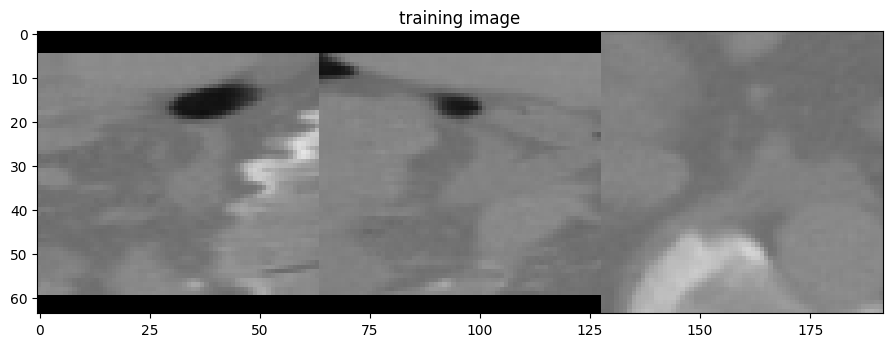

Val image shape torch.Size([1, 512, 512, 64])


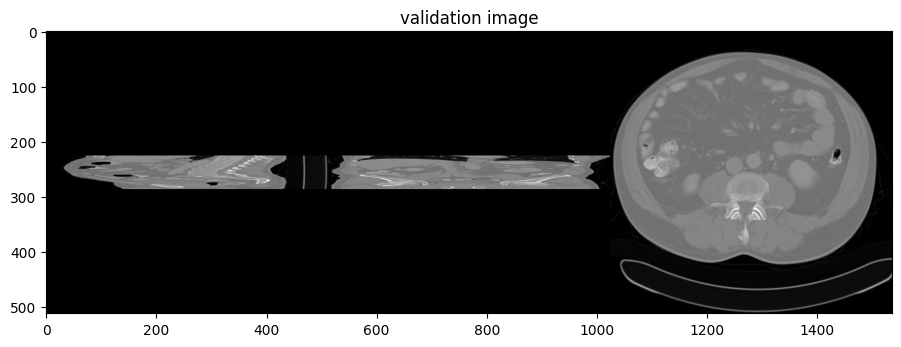

In [11]:
example_vis_img = dataset_train[0]["image"]
print(f"Train image shape {example_vis_img.shape}")
center_loc_axis = find_label_center_loc(example_vis_img.squeeze(0))
vis_image = get_xyz_plot(example_vis_img, center_loc_axis, mask_bool=False)
show_image(vis_image, title="training image")

example_vis_img = dataset_val[0]["image"]
print(f"Val image shape {example_vis_img.shape}")
center_loc_axis = find_label_center_loc(example_vis_img.squeeze(0))
vis_image = get_xyz_plot(example_vis_img, center_loc_axis, mask_bool=False)
show_image(vis_image, title="validation image")

## Initialize networks

In [12]:
device = torch.device("cuda")

args.autoencoder_def["num_splits"] = 1
autoencoder = define_instance(args, "autoencoder_def").to(device)
discriminator_norm = "INSTANCE"
discriminator = PatchDiscriminator(
    spatial_dims=args.spatial_dims,
    num_layers_d=3,
    channels=32,
    in_channels=1,
    out_channels=1,
    norm=discriminator_norm,
).to(device)

## Training config

In [13]:
# config loss and loss weight
if args.recon_loss == "l2":
    intensity_loss = MSELoss()
    print("Use l2 loss")
else:
    intensity_loss = L1Loss(reduction="mean")
    print("Use l1 loss")
adv_loss = PatchAdversarialLoss(criterion="least_squares")

loss_perceptual = (
    PerceptualLoss(spatial_dims=3, network_type="squeeze", is_fake_3d=True, fake_3d_ratio=0.2).eval().to(device)
)

# config optimizer and lr scheduler
optimizer_g = torch.optim.Adam(params=autoencoder.parameters(), lr=args.lr, eps=1e-06 if args.amp else 1e-08)
optimizer_d = torch.optim.Adam(params=discriminator.parameters(), lr=args.lr, eps=1e-06 if args.amp else 1e-08)


# please adjust the learning rate warmup rule based on your dataset and n_epochs
def warmup_rule(epoch):
    # learning rate warmup rule
    if epoch < 10:
        return 0.01
    elif epoch < 20:
        return 0.1
    else:
        return 1.0


scheduler_g = lr_scheduler.LambdaLR(optimizer_g, lr_lambda=warmup_rule)
scheduler_d = lr_scheduler.LambdaLR(optimizer_d, lr_lambda=warmup_rule)

# set AMP scaler
if args.amp:
    # test use mean reduction for everything
    scaler_g = GradScaler("cuda", init_scale=2.0**8, growth_factor=1.5)
    scaler_d = GradScaler("cuda", init_scale=2.0**8, growth_factor=1.5)

Use l1 loss


## If finetune, load pretrained model weights

In [14]:
if args.finetune:
    checkpoint_autoencoder = torch.load(args.trained_autoencoder_path)
    if "unet_state_dict" in checkpoint_autoencoder.keys():
        checkpoint_autoencoder = checkpoint_autoencoder["unet_state_dict"]
    autoencoder.load_state_dict(checkpoint_autoencoder)
    print(f"Finetune on pretrained model {args.trained_autoencoder_path}")
else:
    print("Train from scratch!")

Finetune on pretrained model models/autoencoder_v1.pt


## Training

lr: [1.0000000000000002e-06]
Epoch 0 train_vae_loss 0.03244903067889511: {'recons_loss': 0.014543404104188085, 'kl_loss': 12407.401000976562, 'p_loss': 0.05554962158203125}.
Save trained autoencoder to ./models/autoencoder.pt
Save trained discriminator to ./models/discriminator.pt
Epoch 0 val_vae_loss 0.04961872814612786: {'recons_loss': 0.007988053373992443, 'kl_loss': 308961.1666666667, 'p_loss': 0.0357818603515625}.
Got best val vae loss.
Save trained autoencoder to ./models/autoencoder_epoch0.pt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.2958984].


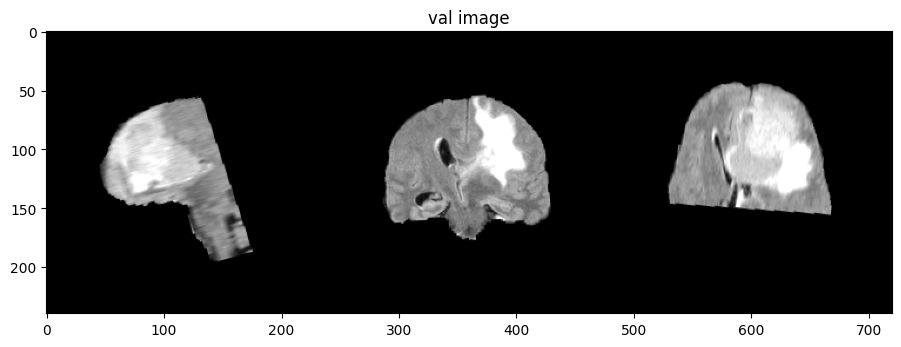

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.046569824..1.3056641].


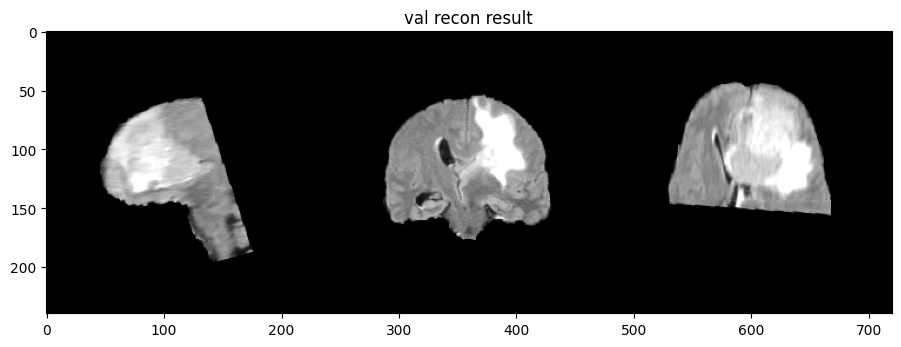

In [15]:
# Initialize variables
val_interval = args.val_interval
best_val_recon_epoch_loss = 10000000.0
total_step = 0
start_epoch = 0
max_epochs = args.n_epochs

# Setup validation inferer
val_inferer = (
    SlidingWindowInferer(
        roi_size=args.val_sliding_window_patch_size,
        sw_batch_size=1,
        progress=False,
        overlap=0.0,
        device=torch.device("cpu"),
        sw_device=device,
    )
    if args.val_sliding_window_patch_size
    else SimpleInferer()
)


def loss_weighted_sum(losses):
    return losses["recons_loss"] + args.kl_weight * losses["kl_loss"] + args.perceptual_weight * losses["p_loss"]


# Training and validation loops
for epoch in range(start_epoch, max_epochs):
    print("lr:", scheduler_g.get_lr())
    autoencoder.train()
    discriminator.train()
    train_epoch_losses = {"recons_loss": 0, "kl_loss": 0, "p_loss": 0}

    for batch in dataloader_train:
        images = batch["image"].to(device).contiguous()
        optimizer_g.zero_grad(set_to_none=True)
        optimizer_d.zero_grad(set_to_none=True)
        with autocast("cuda", enabled=args.amp):
            # Train Generator
            reconstruction, z_mu, z_sigma = autoencoder(images)
            losses = {
                "recons_loss": intensity_loss(reconstruction, images),
                "kl_loss": KL_loss(z_mu, z_sigma),
                "p_loss": loss_perceptual(reconstruction.float(), images.float()),
            }
            logits_fake = discriminator(reconstruction.contiguous().float())[-1]
            generator_loss = adv_loss(logits_fake, target_is_real=True, for_discriminator=False)
            loss_g = loss_weighted_sum(losses) + args.adv_weight * generator_loss

            if args.amp:
                scaler_g.scale(loss_g).backward()
                scaler_g.unscale_(optimizer_g)
                scaler_g.step(optimizer_g)
                scaler_g.update()
            else:
                loss_g.backward()
                optimizer_g.step()

            # Train Discriminator
            logits_fake = discriminator(reconstruction.contiguous().detach())[-1]
            loss_d_fake = adv_loss(logits_fake, target_is_real=False, for_discriminator=True)
            logits_real = discriminator(images.contiguous().detach())[-1]
            loss_d_real = adv_loss(logits_real, target_is_real=True, for_discriminator=True)
            loss_d = (loss_d_fake + loss_d_real) * 0.5

            if args.amp:
                scaler_d.scale(loss_d).backward()
                scaler_d.step(optimizer_d)
                scaler_d.update()
            else:
                loss_d.backward()
                optimizer_d.step()

        # Log training loss
        total_step += 1
        for loss_name, loss_value in losses.items():
            tensorboard_writer.add_scalar(f"train_{loss_name}_iter", loss_value.item(), total_step)
            train_epoch_losses[loss_name] += loss_value.item()
        tensorboard_writer.add_scalar("train_adv_loss_iter", generator_loss, total_step)
        tensorboard_writer.add_scalar("train_fake_loss_iter", loss_d_fake, total_step)
        tensorboard_writer.add_scalar("train_real_loss_iter", loss_d_real, total_step)

    scheduler_g.step()
    scheduler_d.step()
    for key in train_epoch_losses:
        train_epoch_losses[key] /= len(dataloader_train)
    print(f"Epoch {epoch} train_vae_loss {loss_weighted_sum(train_epoch_losses)}: {train_epoch_losses}.")
    for loss_name, loss_value in train_epoch_losses.items():
        tensorboard_writer.add_scalar(f"train_{loss_name}_epoch", loss_value, epoch)
    torch.save(autoencoder.state_dict(), trained_g_path)
    torch.save(discriminator.state_dict(), trained_d_path)
    print("Save trained autoencoder to", trained_g_path)
    print("Save trained discriminator to", trained_d_path)

    # Validation
    if epoch % val_interval == 0:
        autoencoder.eval()
        val_epoch_losses = {"recons_loss": 0, "kl_loss": 0, "p_loss": 0}
        val_loader_iter = iter(dataloader_val)
        for batch in dataloader_val:
            with torch.no_grad():
                with autocast("cuda", enabled=args.amp):
                    images = batch["image"]
                    reconstruction, z_mu, z_sigma = dynamic_infer(val_inferer, autoencoder, images)
                    reconstruction = reconstruction.to(device)
                    val_epoch_losses["recons_loss"] += intensity_loss(reconstruction, images.to(device)).item()
                    val_epoch_losses["kl_loss"] += KL_loss(z_mu, z_sigma).item()
                    val_epoch_losses["p_loss"] += loss_perceptual(reconstruction, images.to(device)).item()

        for key in val_epoch_losses:
            val_epoch_losses[key] /= len(dataloader_val)

        val_loss_g = loss_weighted_sum(val_epoch_losses)
        print(f"Epoch {epoch} val_vae_loss {val_loss_g}: {val_epoch_losses}.")

        if val_loss_g < best_val_recon_epoch_loss:
            best_val_recon_epoch_loss = val_loss_g
            trained_g_path_epoch = f"{trained_g_path[:-3]}_epoch{epoch}.pt"
            torch.save(autoencoder.state_dict(), trained_g_path_epoch)
            print("Got best val vae loss.")
            print("Save trained autoencoder to", trained_g_path_epoch)

        for loss_name, loss_value in val_epoch_losses.items():
            tensorboard_writer.add_scalar(loss_name, loss_value, epoch)

        # Monitor scale_factor
        # We'd like to tune kl_weights in order to make scale_factor close to 1.
        scale_factor_sample = 1.0 / z_mu.flatten().std()
        tensorboard_writer.add_scalar("val_one_sample_scale_factor", scale_factor_sample, epoch)

        # Monitor reconstruction result
        center_loc_axis = find_label_center_loc(images[0, 0, ...])
        vis_image = get_xyz_plot(images[0, ...], center_loc_axis, mask_bool=False)
        vis_recon_image = get_xyz_plot(reconstruction[0, ...], center_loc_axis, mask_bool=False)

        tensorboard_writer.add_image(
            "val_orig_img",
            vis_image.transpose([2, 0, 1]),
            epoch,
        )
        tensorboard_writer.add_image(
            "val_recon_img",
            vis_recon_image.transpose([2, 0, 1]),
            epoch,
        )

        show_image(vis_image, title="val image")
        show_image(vis_recon_image, title="val recon result")